In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils.utils import *
import math

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# Set up paths
script_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
tableu_dir = os.path.join(root_dir, 'tableau')
porcessed_data_dir = os.path.join(script_dir, 'processed_data')

In [29]:
k = 3
eps = 1.7
row_n = 1000
# Load labeled data
labeled_scenarios_df = pd.read_csv(os.path.join(porcessed_data_dir, f'bardis_ensemble_python_ver_{row_n}_k{k}_eps{eps}.csv'))
labeled_scenarios_df

Resources   Economy  Bureaucracy  Pollution   time  run_id  \
0         1.000000  1.000000     1.000000   1.000000    0.0     1.0   
1         0.983784  1.000960     0.998752   1.016100    0.2     1.0   
2         0.967711  1.001403     0.997471   1.031933    0.4     1.0   
3         0.951795  1.001332     0.996156   1.047494    0.6     1.0   
4         0.936050  1.000748     0.994805   1.062779    0.8     1.0   
...            ...       ...          ...        ...    ...     ...   
1000995  -0.000081 -0.000107     0.340252   0.059603  199.2  1000.0   
1000996  -0.000081 -0.000107     0.339812   0.059526  199.4  1000.0   
1000997  -0.000081 -0.000107     0.339372   0.059449  199.6  1000.0   
1000998  -0.000081 -0.000107     0.338933   0.059372  199.8  1000.0   
1000999  -0.000081 -0.000107     0.338494   0.059295  200.0  1000.0   

         kmeans_cluster_id  dbscan_cluster_id  
0                        0                  0  
1                        0                  0  
2                        0                  0  
3                        0                  0  
4                        0                  0  
...                    ...                ...  
1000995                  0                  0  
1000996                  0                  0  
1000997                  0                  0  
1000998                  0                  0  
1000999                  0                  0  

[1001000 rows x 8 columns]

In [30]:
# Create a test subset of the data
test_df = labeled_scenarios_df[labeled_scenarios_df['run_id'] < 6].copy()
test_df

Resources   Economy  Bureaucracy  Pollution   time  run_id  \
0          1.000000  1.000000     1.000000   1.000000    0.0     1.0   
1          0.983784  1.000960     0.998752   1.016100    0.2     1.0   
2          0.967711  1.001403     0.997471   1.031933    0.4     1.0   
3          0.951795  1.001332     0.996156   1.047494    0.6     1.0   
4          0.936050  1.000748     0.994805   1.062779    0.8     1.0   
...             ...       ...          ...        ...    ...     ...   
5000  752426.423001 -0.000116    -0.000433  -0.001063  199.2     5.0   
5001  764176.416236 -0.000116    -0.000433  -0.001063  199.4     5.0   
5002  776109.898962 -0.000116    -0.000433  -0.001063  199.6     5.0   
5003  788229.736575 -0.000116    -0.000433  -0.001063  199.8     5.0   
5004  800538.839218 -0.000116    -0.000433  -0.001063  200.0     5.0   

      kmeans_cluster_id  dbscan_cluster_id  
0                     0                  0  
1                     0                  0  
2                     0                  0  
3                     0                  0  
4                     0                  0  
...                 ...                ...  
5000                  0                  0  
5001                  0                  0  
5002                  0                  0  
5003                  0                  0  
5004                  0                  0  

[5005 rows x 8 columns]

## Visualize Clustered Time Series

In [31]:
def plot_time_series_by_variable(df: pd.DataFrame, clustering_type: str, column_to_plot: str, ylim: tuple = (-1, 5)):
    """
    Plots the time series of a specified column for each run_id,
    coloring each line according to its cluster_id.

    Parameters:
    - df: pd.DataFrame containing 'time', 'run_id', 'cluster_id', and the target column.
    - column_to_plot: str, the name of the column to plot over time.
    """
    # Get unique clusters and assign each a color
    clusters = df[clustering_type].unique()
    cluster_colors = {cluster: plt.cm.tab10(i % 10) for i, cluster in enumerate(clusters)}

    # Create plot
    plt.figure(figsize=(12, 6))
    for run_id, run_df in df.groupby('run_id'):
        cluster_id = run_df[clustering_type].iloc[0]
        color = cluster_colors[cluster_id]
        plt.plot(run_df['time'], run_df[column_to_plot], alpha=0.5, color=color, label=f'Cluster {cluster_id}' if f'Cluster {cluster_id}' not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel('Time')
    plt.ylabel(column_to_plot)
    plt.title(f'{column_to_plot} over Time by Run (colored by Cluster ID)')
    plt.legend(title='Cluster ID', loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.ylim(ylim)
    plt.show()

In [32]:
def plot_all_variables(df: pd.DataFrame, clustering_type: str):
    """
    Creates a 2x2 grid of subplots for the columns 'Resources', 'Economy', 'Bureaucracy', and 'Pollution',
    plotting time series for each run_id and coloring lines by cluster_id.
    """
    columns_to_plot = ['Resources', 'Economy', 'Bureaucracy', 'Pollution']
    clusters = df[clustering_type].unique()
    cluster_colors = {cluster: plt.cm.tab10(i % 10) for i, cluster in enumerate(clusters)}

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()

    for i, column in enumerate(columns_to_plot):
        ax = axes[i]
        for run_id, run_df in df.groupby('run_id'):
            cluster_id = run_df[clustering_type].iloc[0]
            color = cluster_colors[cluster_id]
            ax.plot(run_df['time'], run_df[column], color=color)

        ax.set_title(f'{column} over Time')
        ax.set_xlabel('Time')
        ax.set_ylabel(column)
        ax.grid(True)

    # Shared legend
    handles = [plt.Line2D([0], [0], color=cluster_colors[c], label=f'Cluster {c}') for c in clusters]
    fig.legend(handles=handles, title='Cluster ID', loc='upper center', ncol=len(clusters), bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [33]:
def plot_time_series_by_cluster_subplots(df: pd.DataFrame, clustering_type: str, column_to_plot: str):
    """
    Plots time series for each cluster in separate subplots.
    Each subplot contains the time series of all run_ids in that cluster for the selected column,
    and all lines in a subplot share the same color.

    Parameters:
    - df: pd.DataFrame containing the data.
    - column_to_plot: str, the name of the column to plot.
    - title: str, optional, the title for the entire figure.
    """
    clusters = sorted(df[clustering_type].unique())
    n_clusters = len(clusters)
    n_cols = 2
    n_rows = math.ceil(n_clusters / n_cols)

    # Assign a consistent color per cluster using the updated get_cmap
    colormap = plt.get_cmap('tab10', n_clusters)
    cluster_colors = {cluster_id: colormap(i) for i, cluster_id in enumerate(clusters)}

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), squeeze=False)
    axes = axes.flatten()

    for i, cluster_id in enumerate(clusters):
        ax = axes[i]
        color = cluster_colors[cluster_id]
        cluster_df = df[df[clustering_type] == cluster_id]

        for run_id, run_df in cluster_df.groupby('run_id'):
            ax.plot(run_df['time'], run_df[column_to_plot], color=color, alpha=0.9)

        ax.set_title(f'Cluster {cluster_id}')
        ax.set_xlabel('Time')
        ax.set_ylabel(column_to_plot)
        ax.grid(True)

    # Hide any extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Set the title for the entire figure
    fig.suptitle(f'{column_to_plot} Clusters', fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the title
    plt.show()


In [34]:
state_variables = ['Resources', 'Economy', 'Bureaucracy', 'Pollution']

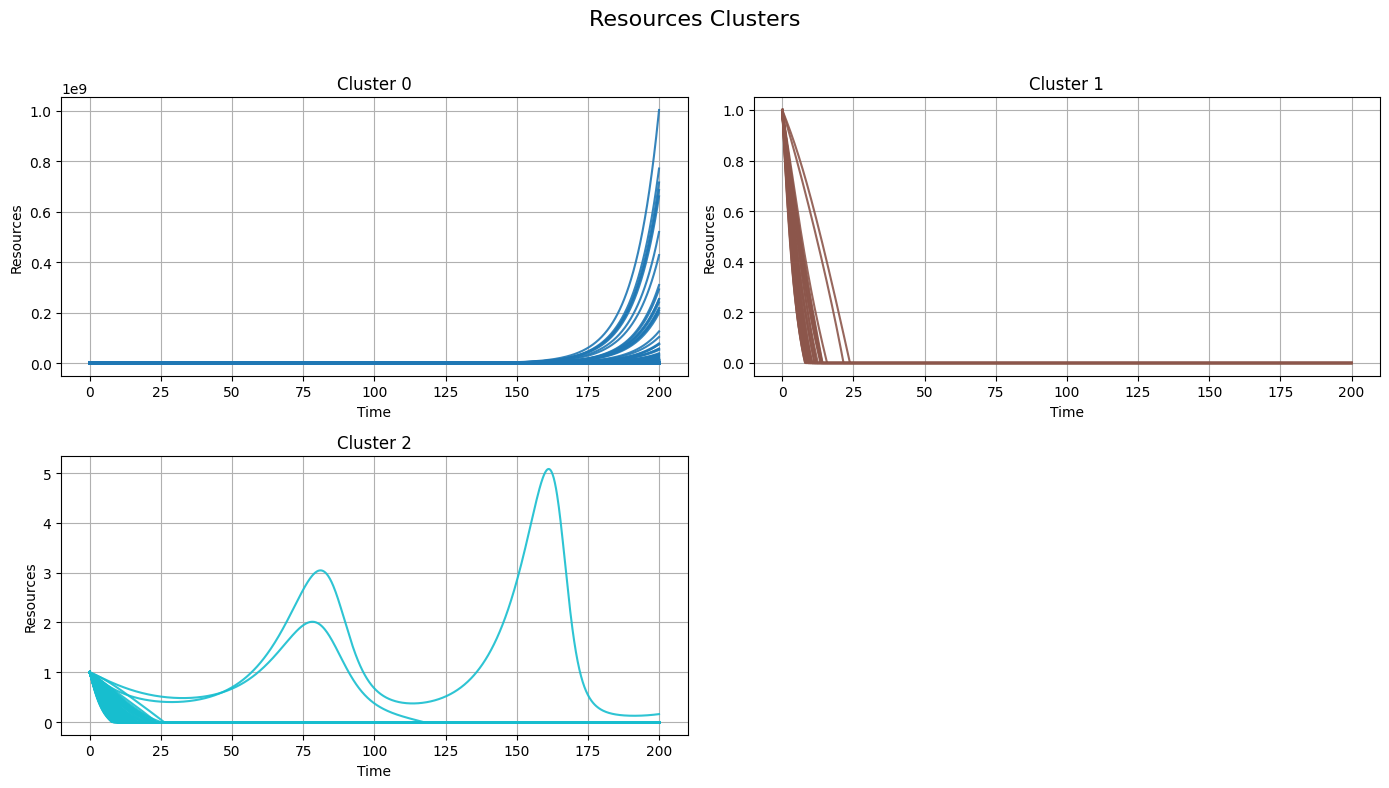

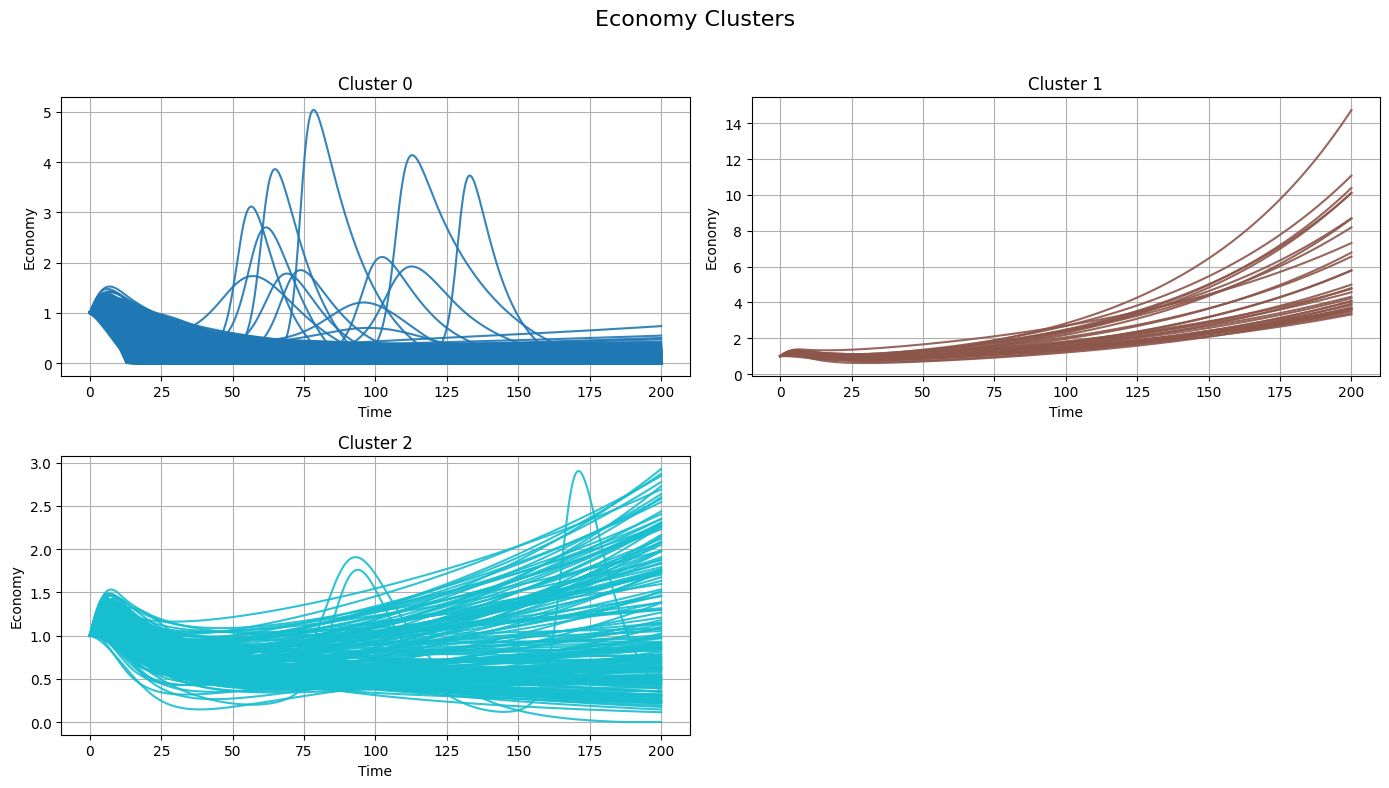

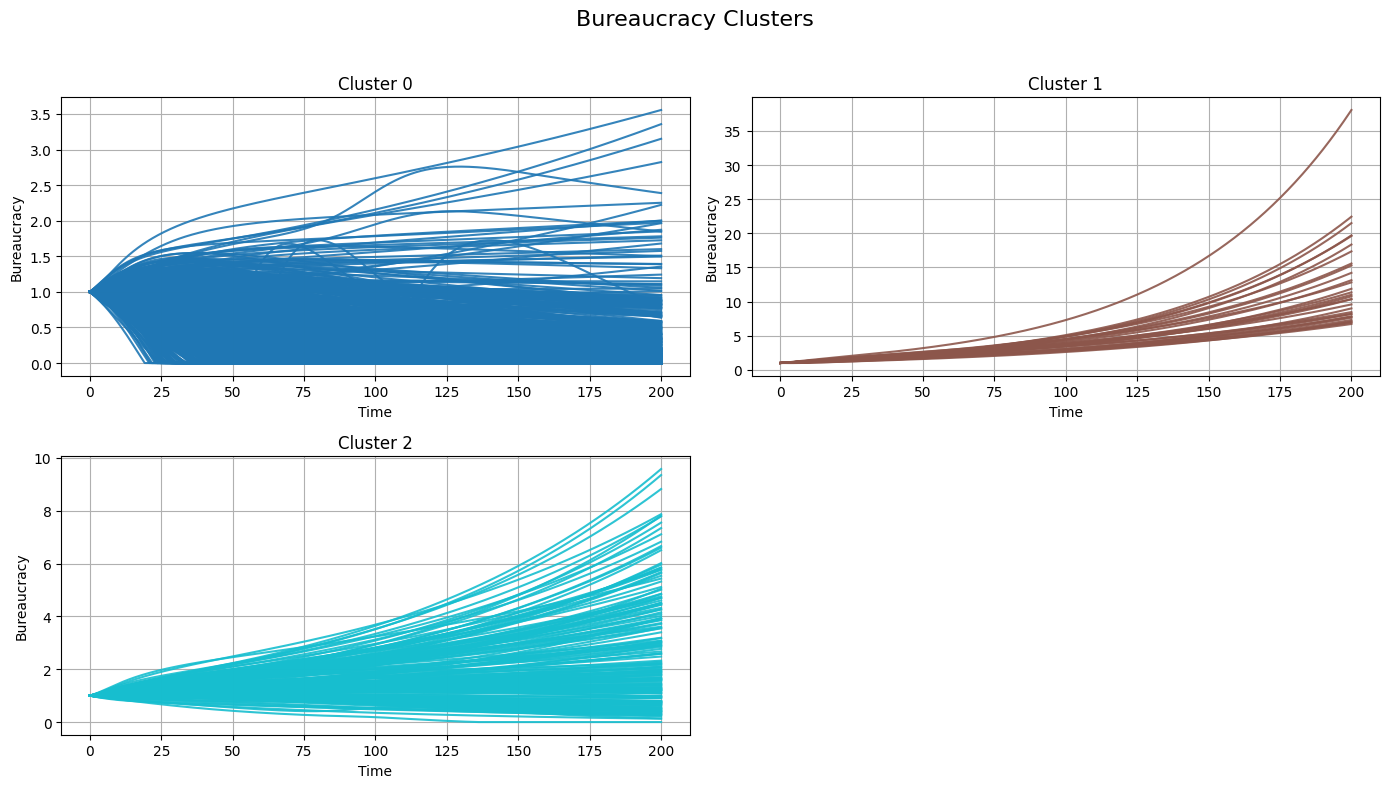

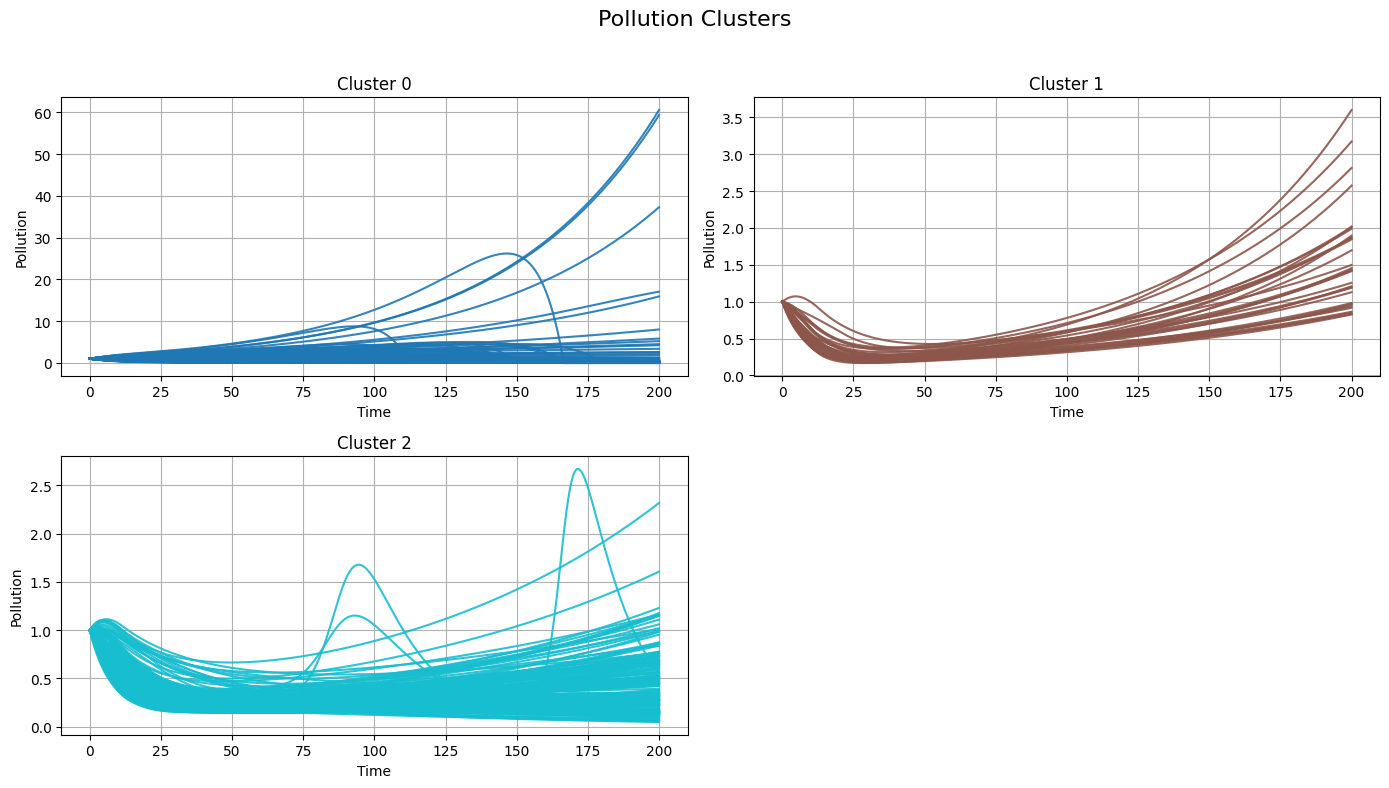

In [35]:
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Resources')
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Economy')
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Bureaucracy')
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Pollution')

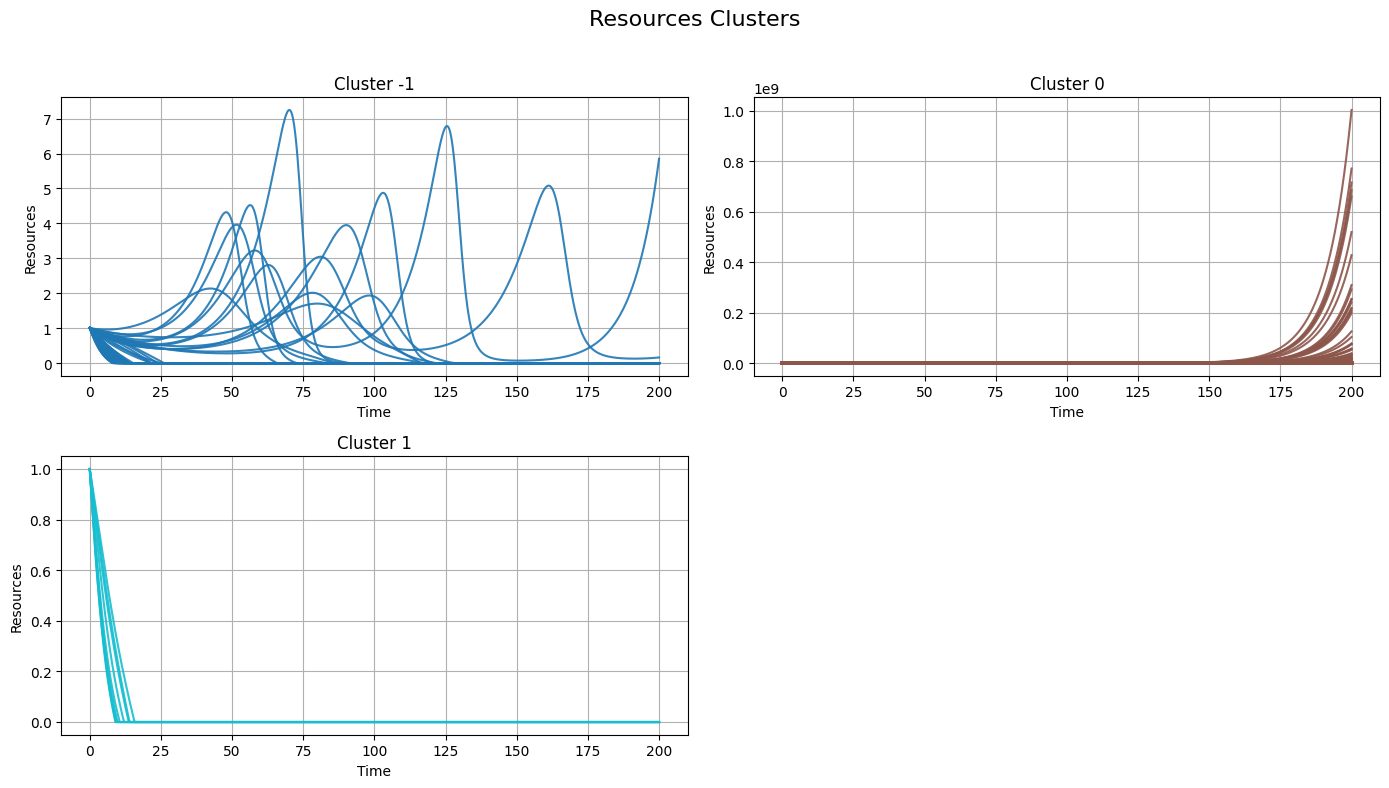

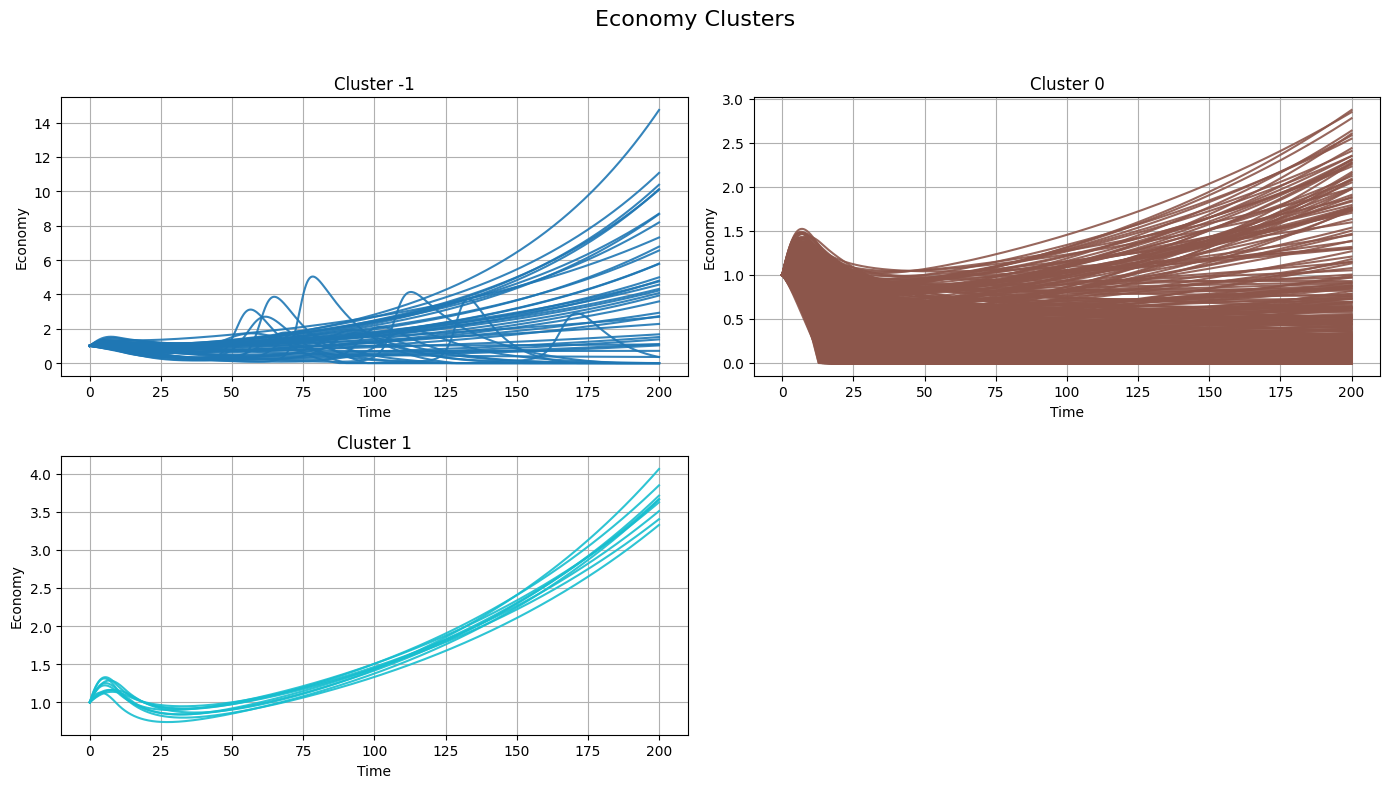

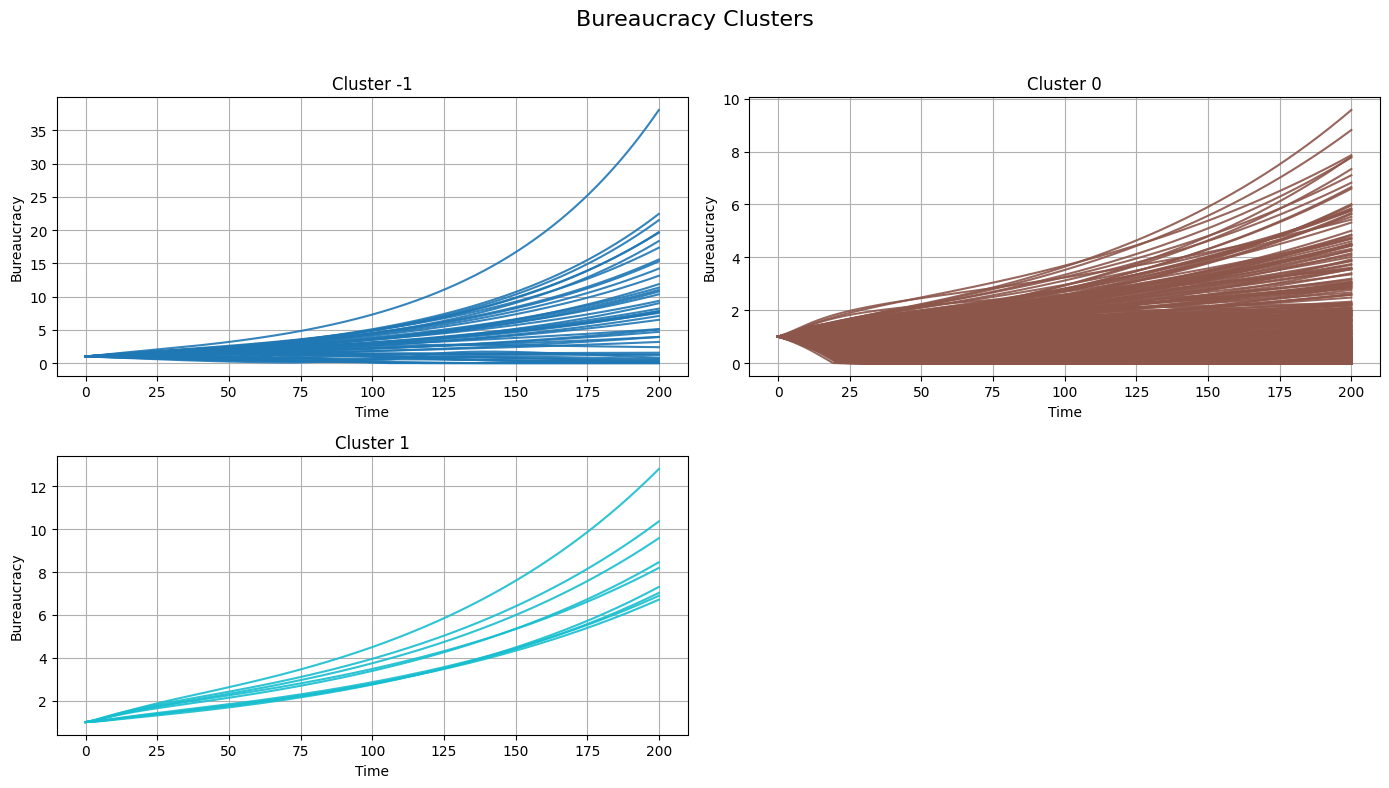

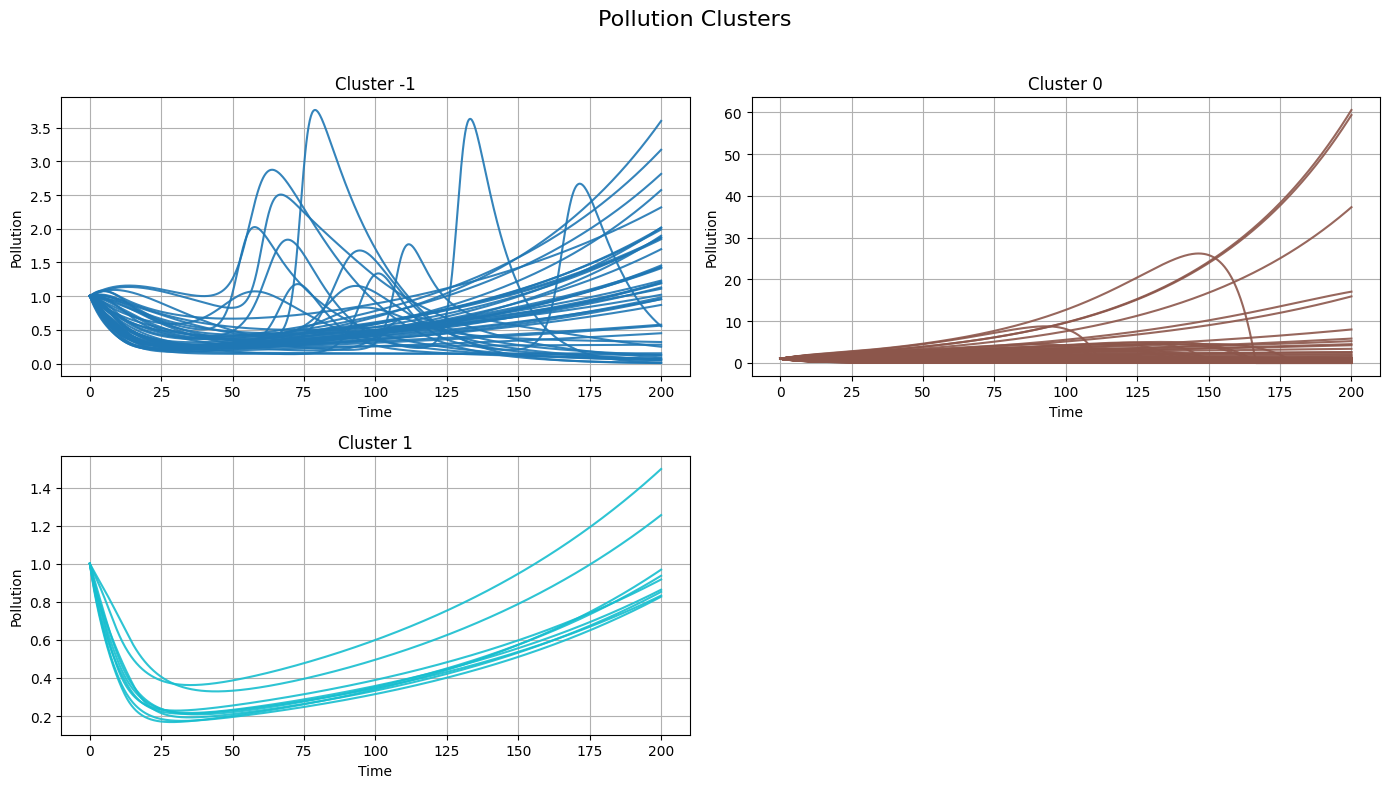

In [36]:
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'dbscan_cluster_id', 'Resources')
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'dbscan_cluster_id', 'Economy')
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'dbscan_cluster_id', 'Bureaucracy')
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'dbscan_cluster_id', 'Pollution')

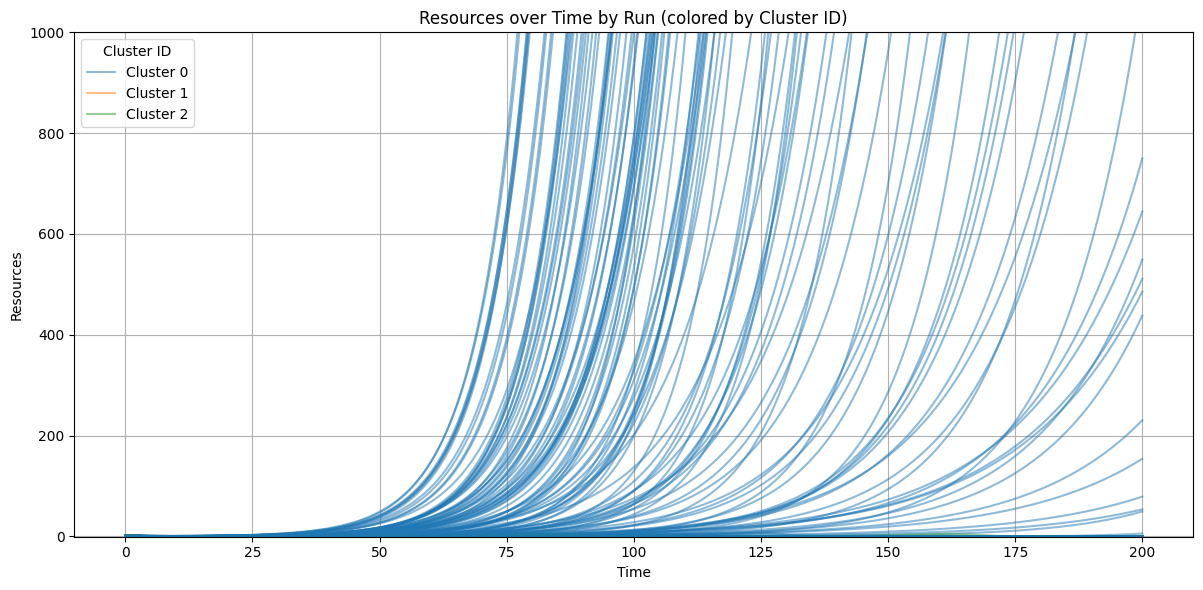

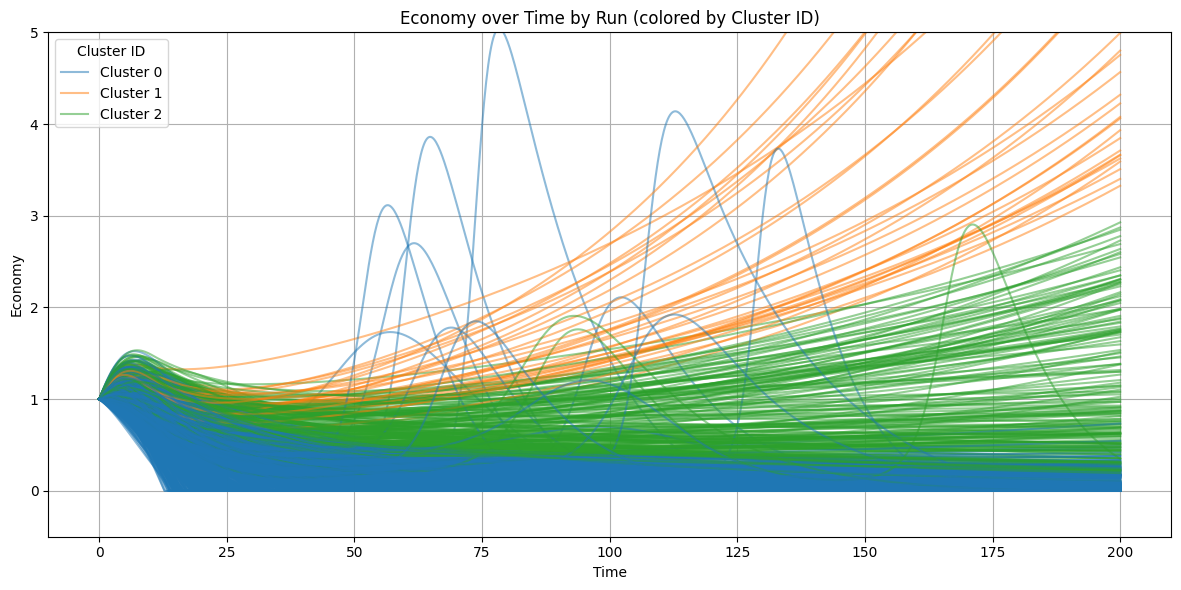

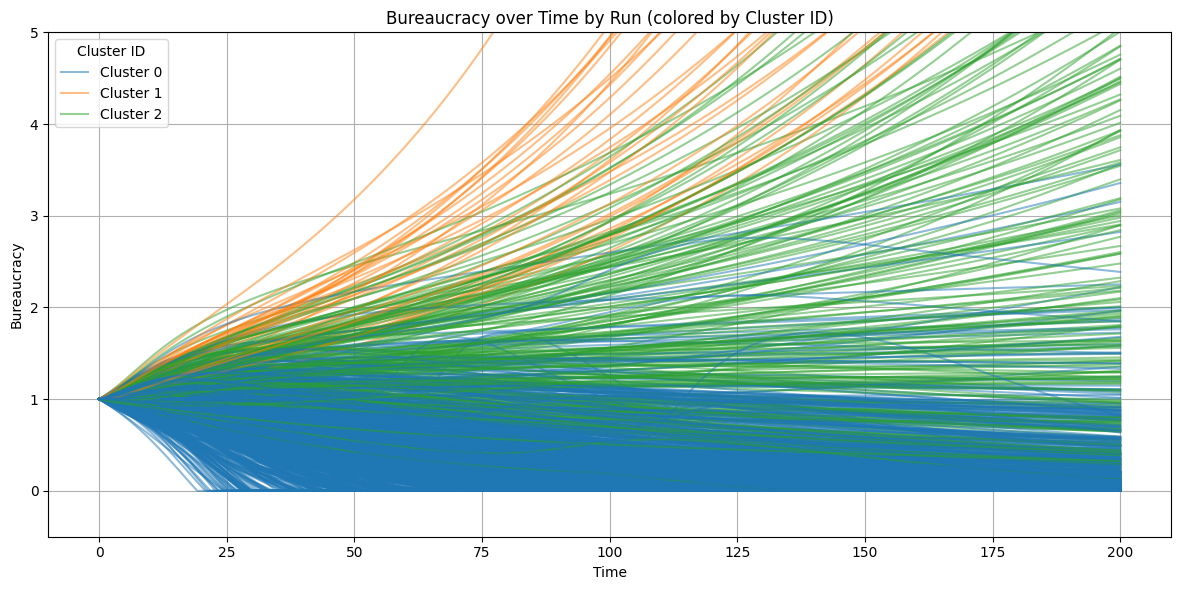

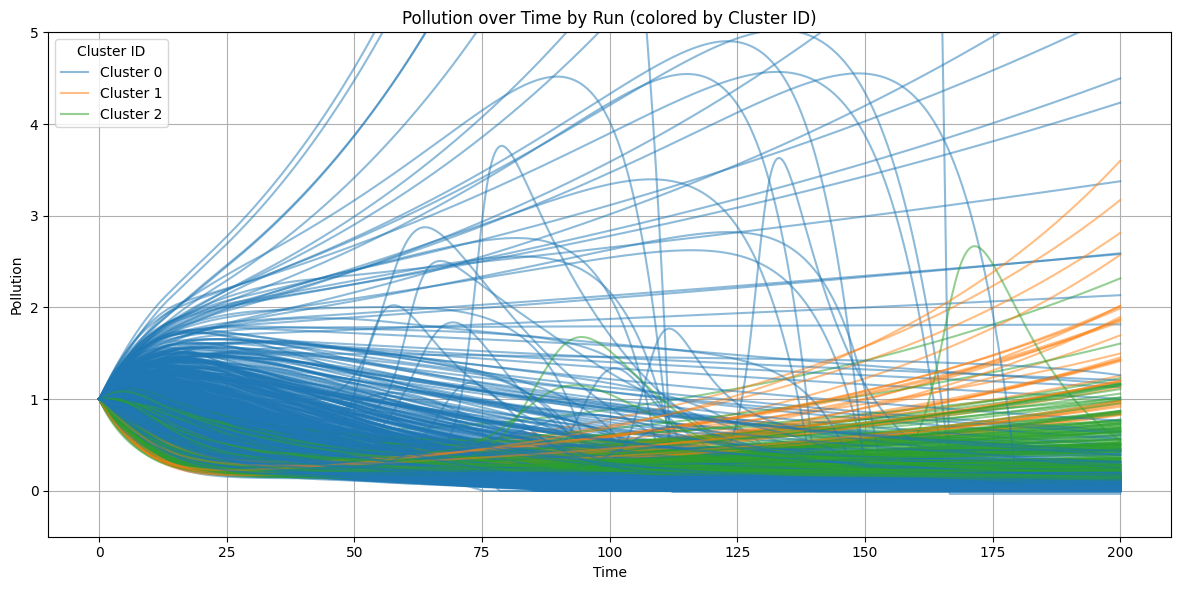

In [38]:
plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Resources', ylim=(-0.5, 1000))
plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Economy', ylim=(-0.5, 5))
plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Bureaucracy', ylim=(-0.5, 5))
plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Pollution', ylim=(-0.5, 5))